# ChromVAR

Run ChromVAR manually.

In [1]:
library(chromVAR)
library(TFBSTools)
library(BSgenome.Hsapiens.UCSC.hg38)
library(Matrix)
library(SummarizedExperiment)
library(motifmatchr)
library(ggplot2)
library(scales)
library(ggseqlogo)
library(BiocParallel)
set.seed(2017)



No methods found in package ‘IRanges’ for request: ‘score’ when loading ‘TFBSTools’

Loading required package: BSgenome

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which.ma

In [18]:
register(MulticoreParam(20, progressbar = TRUE))

In [20]:
# PFM_DIR = './data/neurallike_modisco/'
PFM_DIR = '../20200702_modisco_summarize/data/20200518_n76052/svm/50k/cluster_idx10/pfms/'
PFM_FILES = list.files(PFM_DIR)
PFM_NAMES = lapply(strsplit(PFM_FILES, "\\."), "[[", 1)
PFM_FILES = paste(PFM_DIR, PFM_FILES, sep='')
PFM_NAMES
PFM_FILES

[[1]]
[1] "pattern_0"

[[2]]
[1] "pattern_1"

[[3]]
[1] "pattern_10"

[[4]]
[1] "pattern_11"

[[5]]
[1] "pattern_12"

[[6]]
[1] "pattern_13"

[[7]]
[1] "pattern_14"

[[8]]
[1] "pattern_15"

[[9]]
[1] "pattern_16"

[[10]]
[1] "pattern_17"

[[11]]
[1] "pattern_18"

[[12]]
[1] "pattern_19"

[[13]]
[1] "pattern_2"

[[14]]
[1] "pattern_20"

[[15]]
[1] "pattern_21"

[[16]]
[1] "pattern_22"

[[17]]
[1] "pattern_23"

[[18]]
[1] "pattern_24"

[[19]]
[1] "pattern_3"

[[20]]
[1] "pattern_4"

[[21]]
[1] "pattern_5"

[[22]]
[1] "pattern_6"

[[23]]
[1] "pattern_7"

[[24]]
[1] "pattern_8"

[[25]]
[1] "pattern_9"

[1] "../20200702_modisco_summarize/data/20200518_n76052/svm/50k/cluster_idx10/pfms/pattern_0.pfm" 
 [2] "../20200702_modisco_summarize/data/20200518_n76052/svm/50k/cluster_idx10/pfms/pattern_1.pfm" 
 [3] "../20200702_modisco_summarize/data/20200518_n76052/svm/50k/cluster_idx10/pfms/pattern_10.pfm"
 [4] "../20200702_modisco_summarize/data/20200518_n76052/svm/50k/cluster_idx10/pfms/pattern_11.pfm"
 [5] "../20200702_modisco_summarize/data/20200518_n76052/svm/50k/cluster_idx10/pfms/pattern_12.pfm"
 [6] "../20200702_modisco_summarize/data/20200518_n76052/svm/50k/cluster_idx10/pfms/pattern_13.pfm"
 [7] "../20200702_modisco_summarize/data/20200518_n76052/svm/50k/cluster_idx10/pfms/pattern_14.pfm"
 [8] "../20200702_modisco_summarize/data/20200518_n76052/svm/50k/cluster_idx10/pfms/pattern_15.pfm"
 [9] "../20200702_modisco_summarize/data/20200518_n76052/svm/50k/cluster_idx10/pfms/pattern_16.pfm"
[10] "../20200702_modisco_summarize/data/20200518_n76052/svm/50k/cluster_idx10/pfms/pattern_17.pfm"
[11] "../20200702_modisco_summarize/data/20200518_n76052/svm/50k/cluster_idx10/pfms/pattern_18.pfm"
[12] "../20200702_modisco_summarize/data/20200518_n76052/svm/50k/cluster_idx10/pfms/pattern_19.pfm"
[13] "../20200702_modisco_summarize/data/20200518_n76052/svm/50k/cluster_idx10/pfms/pattern_2.pfm" 
[14] "../20200702_modisco_summarize/data/20200518_n76052/svm/50k/cluster_idx10/pfms/pattern_20.pfm"
[15] "../20200702_modisco_summarize/data/20200518_n76052/svm/50k/cluster_idx10/pfms/pattern_21.pfm"
[16] "../20200702_modisco_summarize/data/20200518_n76052/svm/50k/cluster_idx10/pfms/pattern_22.pfm"
[17] "../20200702_modisco_summarize/data/20200518_n76052/svm/50k/cluster_idx10/pfms/pattern_23.pfm"
[18] "../20200702_modisco_summarize/data/20200518_n76052/svm/50k/cluster_idx10/pfms/pattern_24.pfm"
[19] "../20200702_modisco_summarize/data/20200518_n76052/svm/50k/cluster_idx10/pfms/pattern_3.pfm" 
[20] "../20200702_modisco_summarize/data/20200518_n76052/svm/50k/cluster_idx10/pfms/pattern_4.pfm" 
[21] "../20200702_modisco_summarize/data/20200518_n76052/svm/50k/cluster_idx10/pfms/pattern_5.pfm" 
[22] "../20200702_modisco_summarize/data/20200518_n76052/svm/50k/cluster_idx10/pfms/pattern_6.pfm" 
[23] "../20200702_modisco_summarize/data/20200518_n76052/svm/50k/cluster_idx10/pfms/pattern_7.pfm" 
[24] "../20200702_modisco_summarize/data/20200518_n76052/svm/50k/cluster_idx10/pfms/pattern_8.pfm" 
[25] "../20200702_modisco_summarize/data/20200518_n76052/svm/50k/cluster_idx10/pfms/pattern_9.pfm"

In [21]:
get_rev_comp <- function(motif_pfm) {
    motif_pfm = motif_pfm[, rev(seq(1,ncol(motif_pfm)))]
    
    stopifnot(rownames(motif_pfm)==c("A","C","G","T"))
    rownames(motif_pfm) = c("T", "G", "C", "A")
    
    motif_pfm = motif_pfm[c("A","C","G","T"), ]
}

load_motif <- function(pfm_path, max_width=20) {
    stopifnot(max_width%%2==0)
    
    # loads motif in a canonical form such that A,C are maximised
    motif_pfm = t(as.matrix(read.table(pfm_path)))
    rownames(motif_pfm) = c("A", "C", "G", "T")
    
    if (ncol(motif_pfm)>max_width) {
        # roughly estimate "center of mass"
        center = as.integer(sum(colMaxs(motif_pfm)*seq(1,ncol(motif_pfm)))/sum(colMaxs(motif_pfm)))
        start = center - (max_width/2)
        end = center + (max_width/2) - 1
        
        if (start < 1) {
            start = 1
            end = max_width
        }
        
        else if (end > ncol(motif_pfm)) {
            end = ncol(motif_pfm)
            start = end - max_width + 1
        }
        
        motif_pfm = motif_pfm[, start:end]
    }
    
    rev_comp_pfm = get_rev_comp(motif_pfm)
    
    # canonicalize (A/C content in first half of motif)
    if (sum(rev_comp_pfm[c("A","C"),1:floor(ncol(rev_comp_pfm)/2)])>sum(motif_pfm[c("A","C"),1:floor(ncol(motif_pfm)/2)])) {
        motif_pfm = rev_comp_pfm
    }
    
    motif_pfm
}

In [22]:
MAX_MOTIF_LEN = 30
pfms = list()

for (i in seq(length(PFM_FILES))) {
    cur_pfm = load_motif(PFM_FILES[i])
    pfms[[i]] = PFMatrix(ID=unlist(PFM_NAMES[i]),
                        name=unlist(PFM_NAMES[i]),
                        bg=c(A=0.25, C=0.25, G=0.25, T=0.25),
                        profileMatrix=cur_pfm)
}

In [23]:
motifs = do.call(PFMatrixList, c(pfms, use.names=T))
motifs

PFMatrixList of length 25

In [24]:
pfms[[1]]@ID

[1] "pattern_0"

In [25]:
to_plot = lapply(pfms, as.matrix)
names(to_plot) = lapply(pfms, function(x) {x@ID})

In [26]:
names(to_plot)

[1] "pattern_0"  "pattern_1"  "pattern_10" "pattern_11" "pattern_12"
 [6] "pattern_13" "pattern_14" "pattern_15" "pattern_16" "pattern_17"
[11] "pattern_18" "pattern_19" "pattern_2"  "pattern_20" "pattern_21"
[16] "pattern_22" "pattern_23" "pattern_24" "pattern_3"  "pattern_4" 
[21] "pattern_5"  "pattern_6"  "pattern_7"  "pattern_8"  "pattern_9"

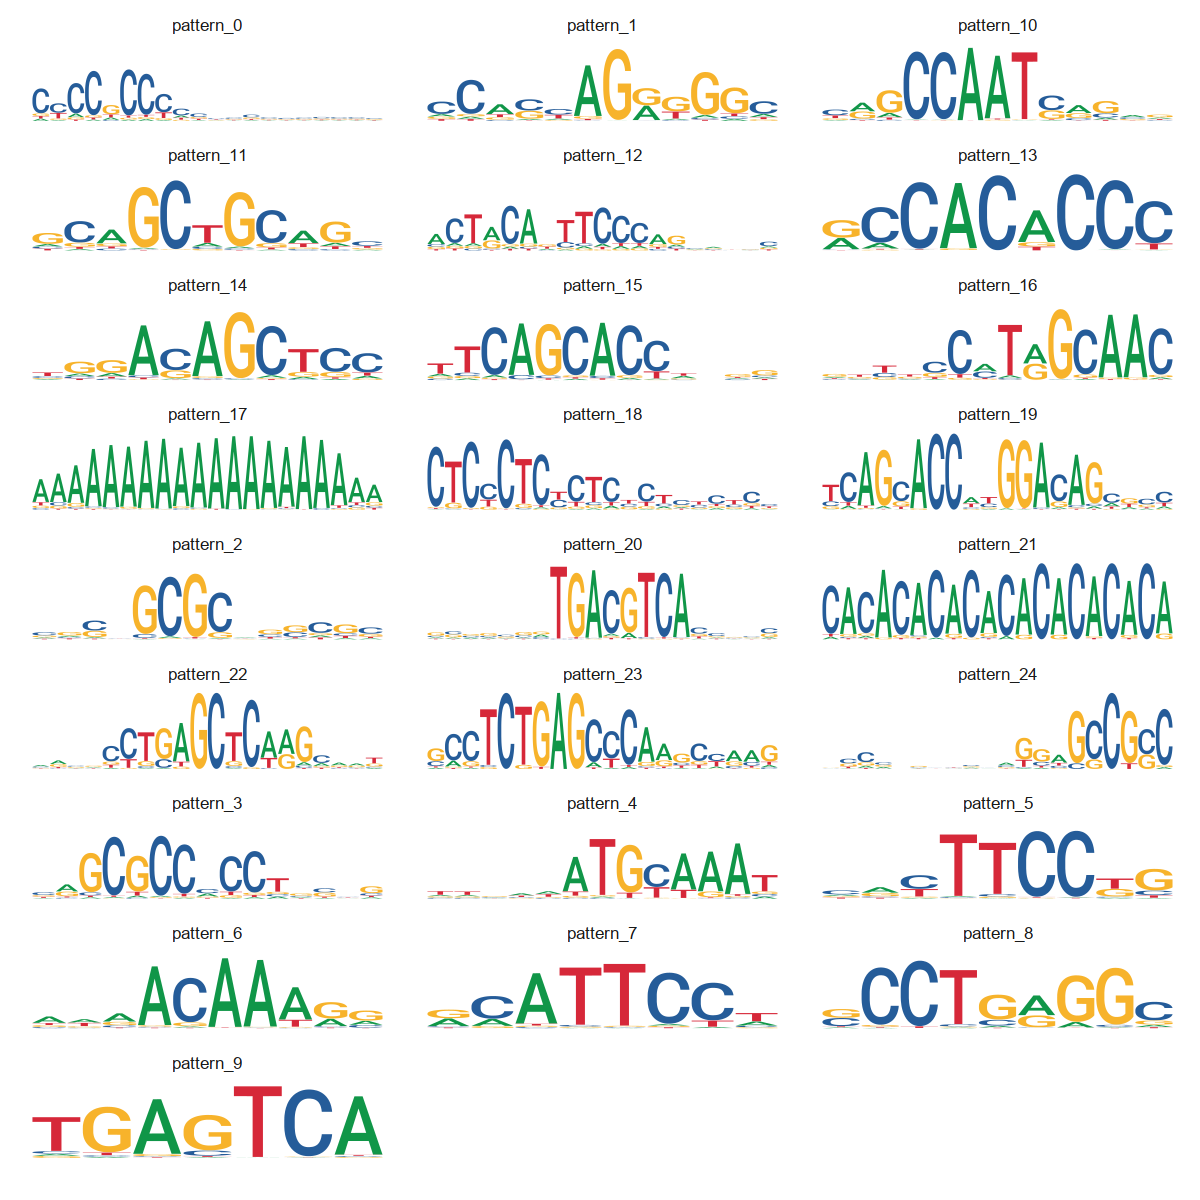

In [27]:
options(repr.plot.width = 10, repr.plot.height = 10)
ggseqlogo(to_plot, ncol=3) +
    theme(axis.text.x = element_blank(),
         axis.text.y = element_blank(),
         axis.title.y = element_blank())

In [28]:
dim(get_rev_comp(to_plot[[2]]))

[1]  4 12

In [29]:
# options(repr.plot.width = 10, repr.plot.height = 5)
# ggseqlogo(list(to_plot[[2]][,19:33], get_rev_comp(to_plot[[13]])[,16:30]), ncol=1) +
# theme(axis.text.x = element_blank(),
#          axis.text.y = element_blank(),
#          axis.title.y = element_blank(),plot.title=element_blank())

In [30]:
motif_names = c()
for (i in seq(length(motifs))) {
    motif_names = c(motif_names, name(motifs[[i]]))
}
motif_names

[1] "pattern_0"  "pattern_1"  "pattern_10" "pattern_11" "pattern_12"
 [6] "pattern_13" "pattern_14" "pattern_15" "pattern_16" "pattern_17"
[11] "pattern_18" "pattern_19" "pattern_2"  "pattern_20" "pattern_21"
[16] "pattern_22" "pattern_23" "pattern_24" "pattern_3"  "pattern_4" 
[21] "pattern_5"  "pattern_6"  "pattern_7"  "pattern_8"  "pattern_9"

### Or Load Precomputed Peaks x Motif Hits Matrix

In [331]:
motifs_bpnet_hits = readMM("../20200723_motif_annotation/bpnet_scores/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40/peaks.overlap.smallpeaks.hits.bpnet.01.mm")

In [332]:
dim(motifs_bpnet_hits)

[1] 803958    110

In [333]:
motif_bpnet_hits_names = read.table("../20200723_motif_annotation/bpnet_scores/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40/peaks.overlap.smallpeaks.hits.bpnet.01.motif.names.txt")
motif_bpnet_hits_names = as.character(unlist(motif_bpnet_hits_names$V1))

In [334]:
length(motif_bpnet_hits_names)

[1] 110

In [335]:
motif_bpnet_hits_se <- SummarizedExperiment(
                 assays = list(motifMatches = motifs_bpnet_hits), 
                 colData = DataFrame(name=motif_bpnet_hits_names)
    );

## Load Data

In [3]:
pmat = readMM("../20200206_pmat_snapATAC/sessions/20200520_n68916/pmat.overlap.smallpeaks.sparse.mm")
pmat = as(pmat, "dgCMatrix")
dim(pmat)

[1]  68916 803958

In [4]:
# Metadata file from previous run
# should contain, sample_barcode as rowname, sample, umap1, umap2, cluster
metaData = read.table("../20200206_pmat_snapATAC/sessions/20200520_n68916/metadata.tsv", header = T)
rownames(metaData) = paste(metaData$sample, metaData$barcode, sep='_')
metaData$cells = rownames(metaData) # for cicero
dim(metaData)
head(metaData, 5)

[1] 68916     5

,barcode,sample,umap1,umap2,cells
,<fct>,<fct>,<dbl>,<dbl>,<chr>
D0_AAACAACGACGATTAC,AAACAACGACGATTAC,D0,6.565758,-8.649868,D0_AAACAACGACGATTAC
D0_AAACAACGAGCGCACT,AAACAACGAGCGCACT,D0,5.604522,-7.835411,D0_AAACAACGAGCGCACT
D0_AAACACGCTACGCCAC,AAACACGCTACGCCAC,D0,5.130516,-7.593246,D0_AAACACGCTACGCCAC
D0_AAACACGCTAGTACGG,AAACACGCTAGTACGG,D0,4.926843,-8.365463,D0_AAACACGCTAGTACGG
D0_AAACACGCTCCTCAAA,AAACACGCTCCTCAAA,D0,6.056337,-5.647577,D0_AAACACGCTCCTCAAA


In [5]:
regions = read.table("../20200206_pmat_snapATAC/sessions/20200520_n68916/peaks.overlap.smallpeaks.bed")
names(regions) = c("chr", "bp1", "bp2")
regions$site_name <- paste(regions$chr, regions$bp1, regions$bp2, sep="_")
row.names(regions) <- regions$site_name
dim(regions)
head(regions)

[1] 803958      4

,chr,bp1,bp2,site_name
,<fct>,<int>,<int>,<chr>
chr1_97145604_97145864,chr1,97145604,97145864,chr1_97145604_97145864
chr1_7538148_7538363,chr1,7538148,7538363,chr1_7538148_7538363
chr1_93196678_93196894,chr1,93196678,93196894,chr1_93196678_93196894
chr1_187577713_187577913,chr1,187577713,187577913,chr1_187577713_187577913
chr1_53278065_53278265,chr1,53278065,53278265,chr1_53278065_53278265
chr1_177176832_177177032,chr1,177176832,177177032,chr1_177176832_177177032


In [6]:
peaks_gr = GRanges(sub("_", "-", sub("_", ":", rownames(regions))))
peaks_gr

GRanges object with 803958 ranges and 0 metadata columns:
           seqnames              ranges strand
              <Rle>           <IRanges>  <Rle>
       [1]     chr1   97145604-97145864      *
       [2]     chr1     7538148-7538363      *
       [3]     chr1   93196678-93196894      *
       [4]     chr1 187577713-187577913      *
       [5]     chr1   53278065-53278265      *
       ...      ...                 ...    ...
  [803954]     chrY     7500307-7500509      *
  [803955]     chrY     7447984-7448191      *
  [803956]     chrY   14733640-14733856      *
  [803957]     chrY   12662452-12662752      *
  [803958]     chrY   12681580-12681865      *
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths

In [7]:
# binarize the matrix (could also do outlier removal)
pmat@x[pmat@x > 0] <- 1

In [8]:
pmatRowSums = Matrix::rowSums(pmat)

In [9]:
pmatColSums = Matrix::colSums(pmat)

In [10]:
min(pmatRowSums)

[1] 316

In [11]:
min(pmatColSums)

[1] 21

## ChromVAR

In [13]:
GENOME = BSgenome.Hsapiens.UCSC.hg38

In [14]:
rse <- SummarizedExperiment(
                 assays = list(counts = t(pmat)), 
                 rowRanges = peaks_gr, 
                 colData = DataFrame(Cell_Type=1:nrow(pmat), depth=pmatRowSums)
    );

In [15]:
rse <- addGCBias(rse, genome = GENOME);

---
Match motifs

In [336]:
motif_mm <- matchMotifs(motifs, rse, genome = GENOME)

Or use pre-computed matrix, e.g. from BPNet hits loaded above

In [337]:
motif_mm <- motif_bpnet_hits_se

---

In [338]:
motif_mm_mat = assay(motif_mm)
colnames(motif_mm_mat) = motif_mm$name

In [ ]:
dev <- computeDeviations(object = rse, annotations = motif_mm)

Warning message in matches_check(annotations):
“Annotation object matches converted to logical”


  |===================================                                   |  50%

In [ ]:
dev_mat = t(assay(dev))

In [ ]:
dim(metaData)

In [ ]:
colnames(dev_mat) = motif_mm$name
rownames(dev_mat) = rownames(metaData)
head(dev_mat)

In [353]:
# save output
write.table(dev_mat, file="./out/20200520_n68916/20200803_BPNet_hits.tsv", quote=F, row.names=T, sep='\t')

In [343]:
variability <- computeVariability(dev)

  |======================================================================| 100%



In [344]:
head(variability)

,name,variability,bootstrap_lower_bound,bootstrap_upper_bound,p_value,p_value_adj
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,AP-1(bZIP),10.457709,10.400504,10.511773,0,0
2,AP-2alpha(AP2),4.241728,4.213970,4.271543,0,0
3,AP-2gamma(AP2),4.272849,4.244903,4.301355,0,0
4,Ap4(bHLH),3.358968,3.339405,3.378977,0,0
5,Ascl2(bHLH),2.126475,2.113134,2.138976,0,0
6,Atf1(bZIP),2.561056,2.546666,2.575289,0,0


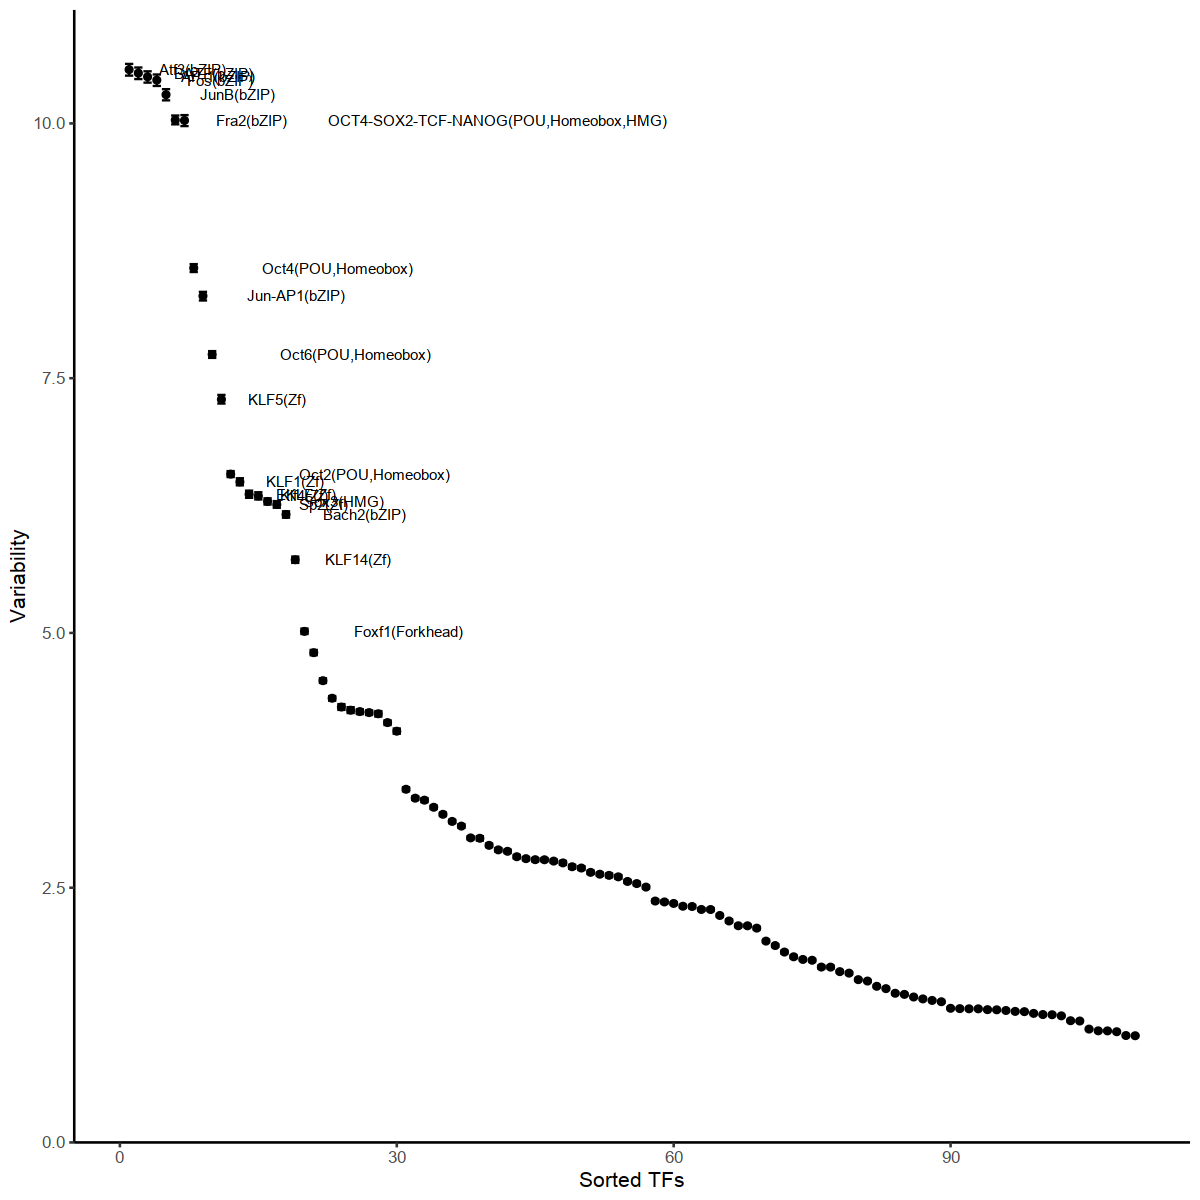

In [345]:
plotVariability(variability, use_plotly = FALSE, n = 20) 

In [346]:
variability[rev(order(variability$variability)), "name"]

[1] Atf3(bZIP)                           
  [2] BATF(bZIP)                           
  [3] AP-1(bZIP)                           
  [4] Fos(bZIP)                            
  [5] JunB(bZIP)                           
  [6] OCT4-SOX2-TCF-NANOG(POU,Homeobox,HMG)
  [7] Fra2(bZIP)                           
  [8] Oct4(POU,Homeobox)                   
  [9] Jun-AP1(bZIP)                        
 [10] Oct6(POU,Homeobox)                   
 [11] KLF5(Zf)                             
 [12] Oct2(POU,Homeobox)                   
 [13] KLF1(Zf)                             
 [14] EKLF(Zf)                             
 [15] Klf4(Zf)                             
 [16] Sox3(HMG)                            
 [17] Sp2(Zf)                              
 [18] Bach2(bZIP)                          
 [19] KLF14(Zf)                            
 [20] Foxf1(Forkhead)                      
 [21] FoxL2(Forkhead)                      
 [22] Sp5(Zf)                              
 [23] RUNX-AML(Runt)                       
 [24] AP-2gamma(AP2)                       
 [25] AP-2alpha(AP2)                       
 [26] RUNX1(Runt)                          
 [27] RUNX2(Runt)                          
 [28] CTCF(Zf)                             
 [29] RUNX(Runt)                           
 [30] BORIS(Zf)                            
 [31] Tcf21(bHLH)                          
 [32] NF-E2(bZIP)                          
 [33] Ap4(bHLH)                            
 [34] Bach1(bZIP)                          
 [35] Sox4(HMG)                            
 [36] Nrf2(bZIP)                           
 [37] NeuroG2(bHLH)                        
 [38] Sox9(HMG)                            
 [39] CEBP(bZIP)                           
 [40] Atoh1(bHLH)                          
 [41] MyoG(bHLH)                           
 [42] NF1(CTF)                             
 [43] Olig2(bHLH)                          
 [44] CREB5(bZIP)                          
 [45] Atf7(bZIP)                           
 [46] ZBTB18(Zf)                           
 [47] c-Jun-CRE(bZIP)                      
 [48] TEAD1(TEAD)                          
 [49] TEAD3(TEA)                           
 [50] Pitx1:Ebox(Homeobox,bHLH)            
 [51] Myf5(bHLH)                           
 [52] Atf2(bZIP)                           
 [53] TEAD(TEA)                            
 [54] TEAD4(TEA)                           
 [55] Atf1(bZIP)                           
 [56] Tcf12(bHLH)                          
 [57] MyoD(bHLH)                           
 [58] Nanog(Homeobox)                      
 [59] HEB(bHLH)                            
 [60] Sp1(Zf)                              
 [61] ERG(ETS)                             
 [62] TEAD2(TEA)                           
 [63] NFAT:AP1(RHD,bZIP)                   
 [64] E2A(bHLH)                            
 [65] EBF1(EBF)                            
 [66] Atf4(bZIP)                           
 [67] Ascl2(bHLH)                          
 [68] Tlx?(NR)                             
 [69] ETS1(ETS)                            
 [70] ETV4(ETS)                            
 [71] IRF1(IRF)                            
 [72] ISRE(IRF)                            
 [73] IRF3(IRF)                            
 [74] JunD(bZIP)                           
 [75] REST-NRSF(Zf)                        
 [76] NFkB-p65-Rel(RHD)                    
 [77] NFkB-p65(RHD)                        
 [78] Six2(Homeobox)                       
 [79] HLF(bZIP)                            
 [80] WT1(Zf)                              
 [81] Six4(Homeobox)                       
 [82] Elk1(ETS)                            
 [83] NF1:FOXA1(CTF,Forkhead)              
 [84] NFY(CCAAT)                           
 [85] Mef2d(MADS)                          
 [86] CRE(bZIP)                            
 [87] Zic3(Zf)                             
 [88] ETS:RUNX(ETS,Runt)                   
 [89] OCT:OCT(POU,Homeobox)                
 [90] Rfx2(HTH)                            
 [91] NRF(NRF)                            

In [347]:
cur_pattern = "Nanog(Homeobox)"

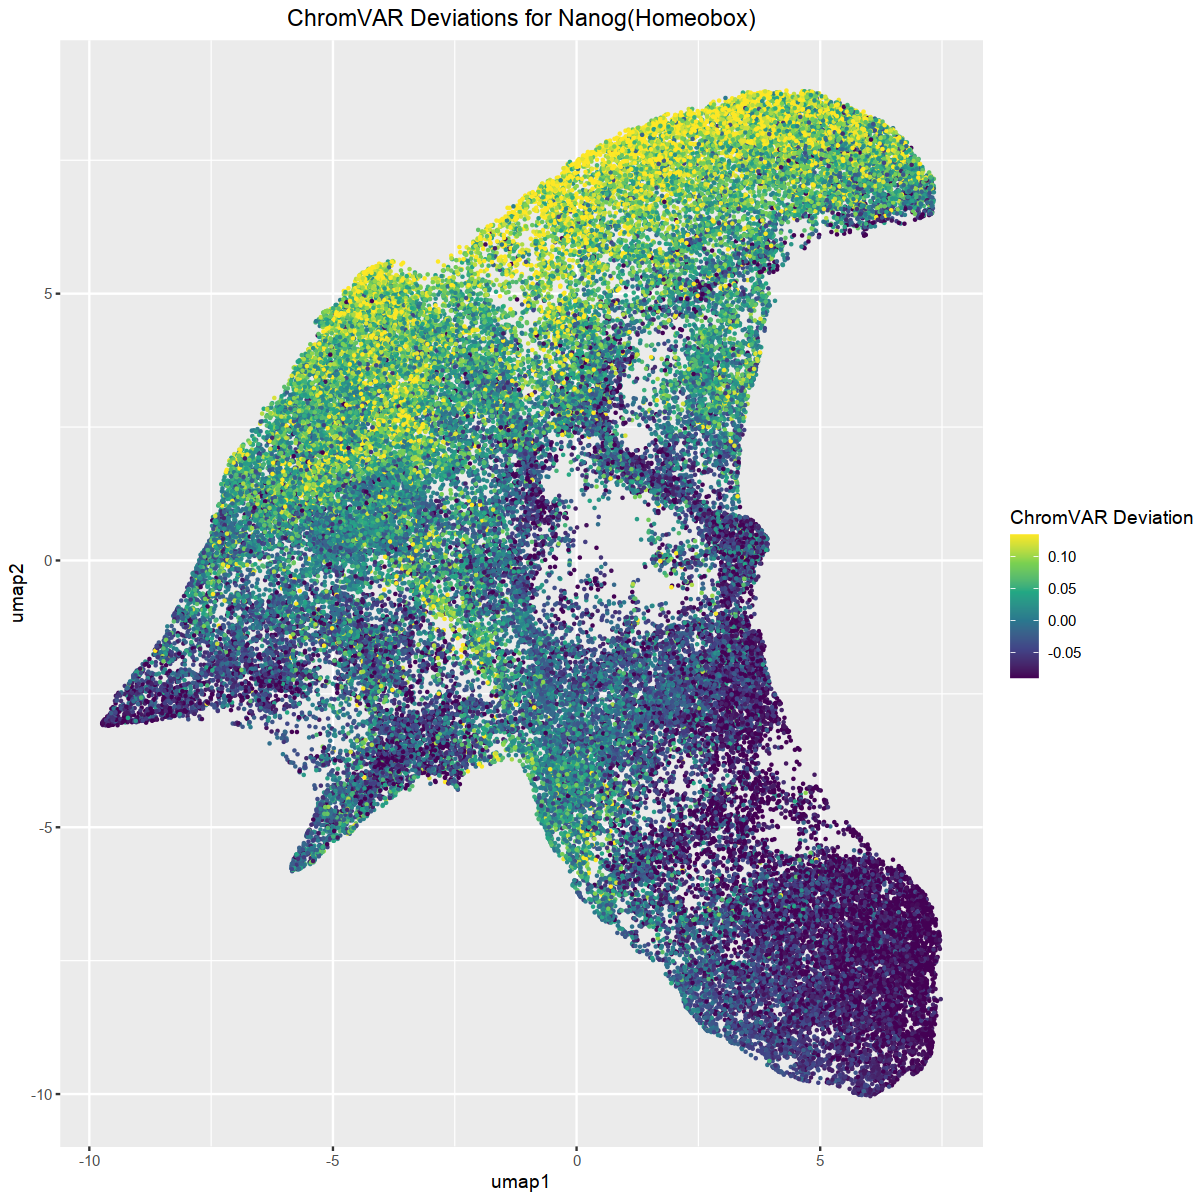

In [355]:
options(repr.plot.width = 10, repr.plot.height = 10)

cur_dev = dev_mat[,cur_pattern]

df = data.frame(metaData, n=cur_dev)
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df) +
geom_point(size=1, stroke=0, alpha=1, aes(x=umap1 , y=umap2, col=n)) +
scale_color_viridis_c(limit=c(quantile(cur_dev, 0.1),
                              quantile(cur_dev, 0.95)), 
                      oob = squish, name='ChromVAR Deviation') +
ggtitle(sprintf("ChromVAR Deviations for %s", cur_pattern)) + 
theme(plot.title = element_text(hjust = 0.5)) 

In [349]:
sum(motif_mm_mat[, cur_pattern])

[1] 69508

In [350]:
frip = 100*Matrix::rowSums(pmat[, motif_mm_mat[, cur_pattern]])/pmatRowSums

In [351]:
cor(frip, dev_mat[,cur_pattern], method='spearman')

[1] 0.4521775

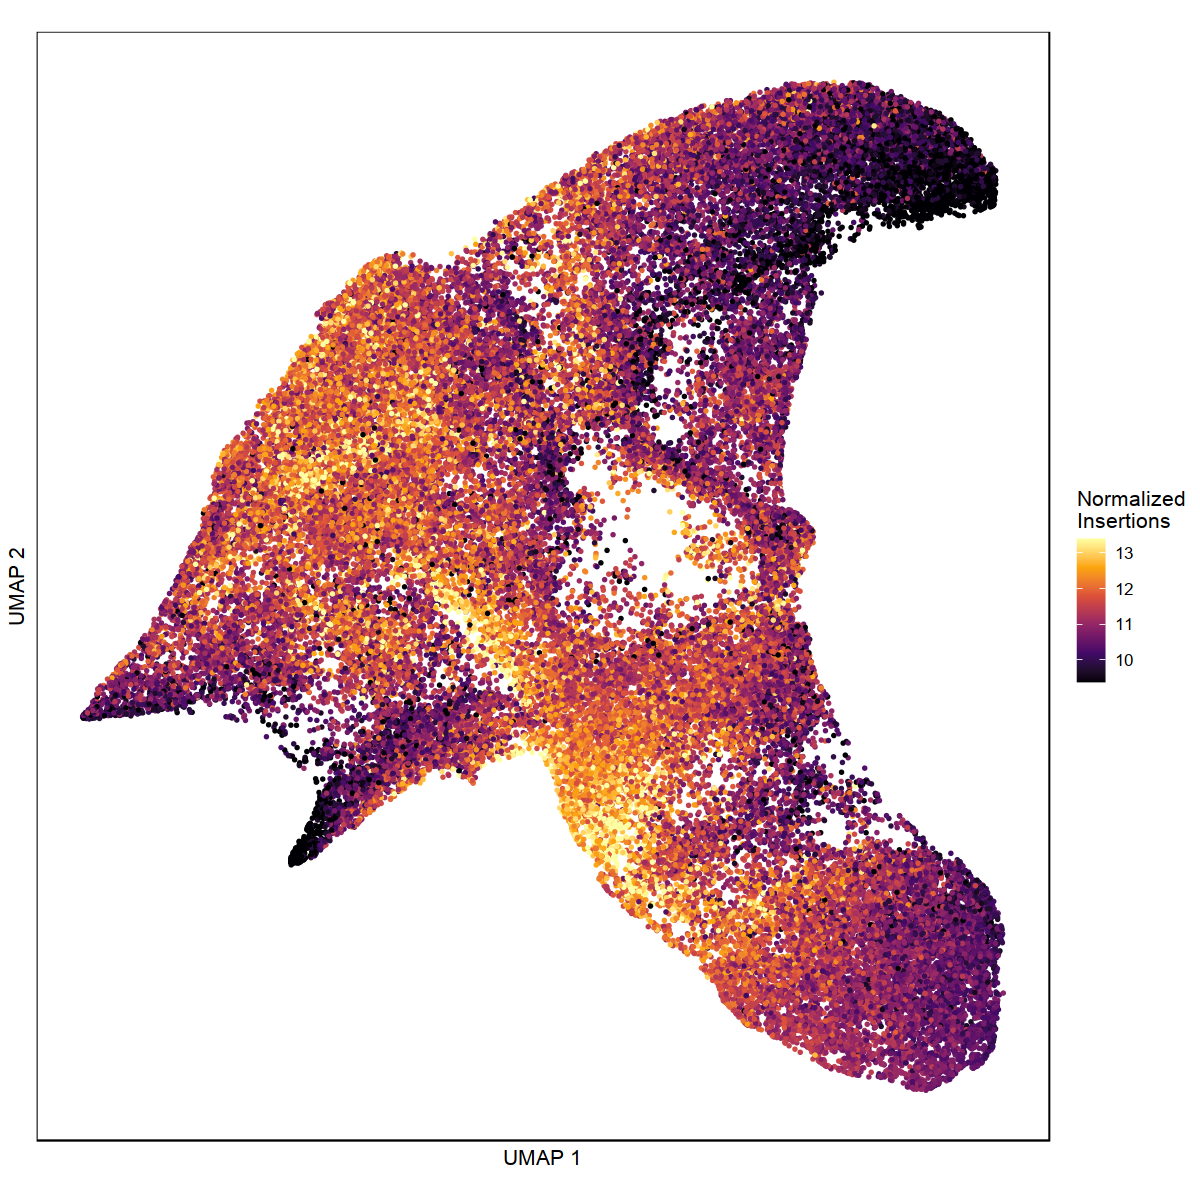

In [352]:
options(repr.plot.width = 10, repr.plot.height = 10)

df = data.frame(metaData, n=frip)
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

frip_plot <- ggplot(df) +
geom_point(size=0.5, alpha=1, aes(x=umap1 , y=umap2, col=n)) +
scale_color_viridis_c(limit=c(quantile(frip, 0.05),
                              quantile(frip, 0.98)), 
                      oob = squish, option="B",
                     name="Normalized\nInsertions") +
theme_classic() +
    xlab("UMAP 1") + ylab("UMAP 2") +
    theme(plot.title = element_text(hjust = 0.5),
          text = element_text(size=12),
          axis.line=element_blank(),
          axis.text.x=element_blank(),
          axis.text.y=element_blank(),
          axis.ticks=element_blank(),
          panel.border = element_rect(colour = "black", fill=NA, size=0.5)) +
# ggtitle(sprintf("FRiP for %s", cur_pattern)) + 
theme(plot.title = element_text(hjust = 0.5)) +
coord_fixed()

frip_plot

### SessionInfo

In [236]:
sessionInfo()

R version 3.6.3 (2020-02-29)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Ubuntu 18.04.4 LTS

Matrix products: default
BLAS/LAPACK: /users/surag/anaconda3/envs/r36_cran/lib/libopenblasp-r0.3.9.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats4    parallel  stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] scales_1.1.0                      ggplot2_3.3.0                    
 [3] motifmatchr_1.8.0                 SummarizedExperiment_1.16.1      
 [5] DelayedArray_0.12.3               BiocParallel_1.20.1              
 [7] matrixStats_0.56.0                Biobase_2.46.0   